# Analyzing the sampled Blackjack data

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time
import json
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

## Plot winnings for different strategies

Plot each strategy with `6_1_H17_[3, 2]` game parameters.

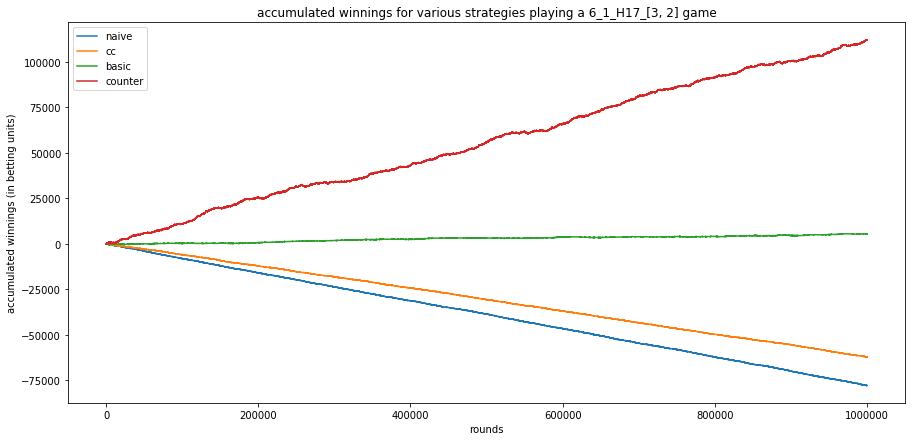

In [55]:
for strat in ['naive','cc','basic']:
    df = pd.read_csv('/media/saa/My Passport/Blackjack/sim_dfs/%s/6_1_H17_[3, 2]_%s.csv'%(strat,strat))
    plt.plot(df['accumulated_winnings'], label=strat)
    
df = pd. read_csv('/media/saa/My Passport/Blackjack/sim_dfs/counter/twelve/6_1_H17_[3, 2]_twelve.csv')
plt.plot(df['accumulated_winnings'], label='counter')
plt.xlabel('rounds')
plt.ylabel('accumulated winnings (in betting units)')
plt.title('accumulated winnings for various strategies playing a 6_1_H17_[3, 2] game')
plt.legend(loc='best')
plt.savefig('plots/6_1_H17_[3, 2]_winnings_plot.jpeg')
plt.show()


## Sampling largest losses


In this section we write a function to sample the largest losses for our samples.  This function will be used in assembling the summary DataFrame. We will use the `'twelve'` spread counter strategy with game parameters `6_1_H17_[3, 2]` to obtain the plots.

In [43]:
df = pd.read_csv('/media/saa/My Passport/Blackjack/sim_dfs/counter/twelve/6_1_H17_[3, 2]_twelve.csv')

In [44]:
# define function returning the empirical cumulative distribution function
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1)/len(x)
    return x, y

In [48]:
# this function samples random intervals of 50,000 rounds
# 100,000 times to compute the distribution of max losses
# for the strategy of the dataframe.

def losses_with_plots(df):
    df.reset_index(drop=True, inplace=True)
    mins = []
    np.random.seed(11)
    start_indexes = np.random.choice(950000, size=100000, replace=False)
    for i in start_indexes:
        sample50k = np.array(df.loc[i:i + 49999, 'accumulated_winnings'])
        if i != 0:
            mins.append(sample50k.min() - df.loc[i-1,'accumulated_winnings'])
        else:
            mins.append(sample50k.min())
            
    plt.boxplot(mins)
    plt.ylabel('minimum accumulated winnings')
    plt.title('6_1_H17_[3, 2]_twelve largest losses boxplot')
    plt.savefig('plots/6_1_H17_[3, 2]_twelve_largest_losses_boxplot.jpeg')
    plt.show()
    
    plt.hist(mins, bins=1000, histtype='step', density=True)
    plt.xlabel('largest losses')
    plt.ylabel('Probability')
    plt.title('6_1_H17_[3, 2]_twelve largest losses histogram')
    plt.savefig('plots/6_1_H17_[3, 2]_twelve_largest_losses_histogram.jpeg')
    plt.show()
    
    x, y = ecdf(mins)
    plt.plot(x, y)
    plt.xlabel('minimum accumulated winnings')
    plt.ylabel('ECDF')
    plt.title('6_1_H17_[3, 2]_twelve largest losses CDF')
    plt.savefig('plots/6_1_H17_[3, 2]_twelve_largest_losses_CDF.jpeg')
    plt.show()
    
    return mins

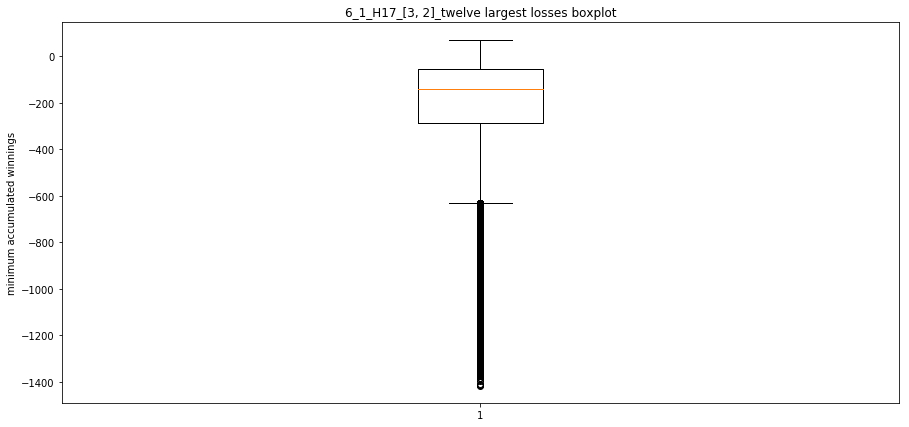

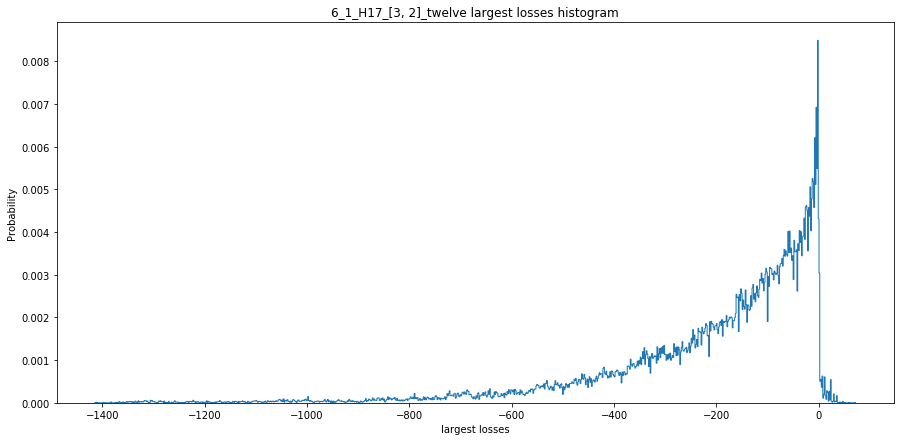

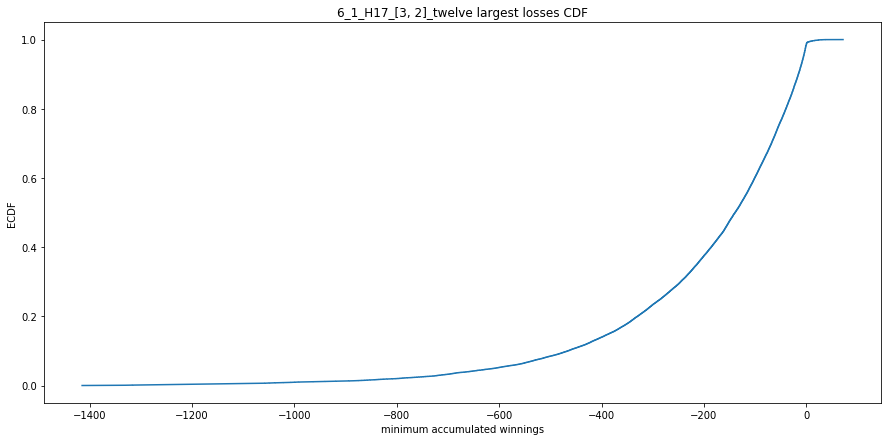

In [47]:
mins = losses_with_plots(df)

In [49]:
# losses function without plots

def losses(df):
    df.reset_index(drop=True, inplace=True)
    mins = []
    np.random.seed(11)
    start_indexes = np.random.choice(950000, size=100000, replace=False)
    for i in start_indexes:
        sample50k = np.array(df.loc[i:i + 49999, 'accumulated_winnings'])
        if i != 0:
            mins.append(sample50k.min() - df.loc[i-1,'accumulated_winnings'])
        else:
            mins.append(sample50k.min())
    return mins

## Correlation between opening count and round winnings

We examine the correlation between opening count and round winnings.   For the sake of illustration we will look at a 6 deck 1 penetration H17 3:2 game playing basic strategy (not a counter strategy since higher counts get higher bets and skew the data).

In [56]:
df = pd.read_csv('/media/saa/My Passport/Blackjack/sim_dfs/basic/6_1_H17_[3, 2]_basic.csv')

Correlation coefficient between `opening_count` and `total_round_winnings`.

In [58]:
coef, p_val = stats.pearsonr(df['opening_count'],df['total_round_winnings'])
print('Correlation coefficient: ', coef)
print('p-value: ', p_val)

Correlation coefficient:  0.0137964008461712
p-value:  2.6553296900597143e-43


Small positive correlation, but the p-value is nearly zero, so this connection between opening count and total round winnings is significant.

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


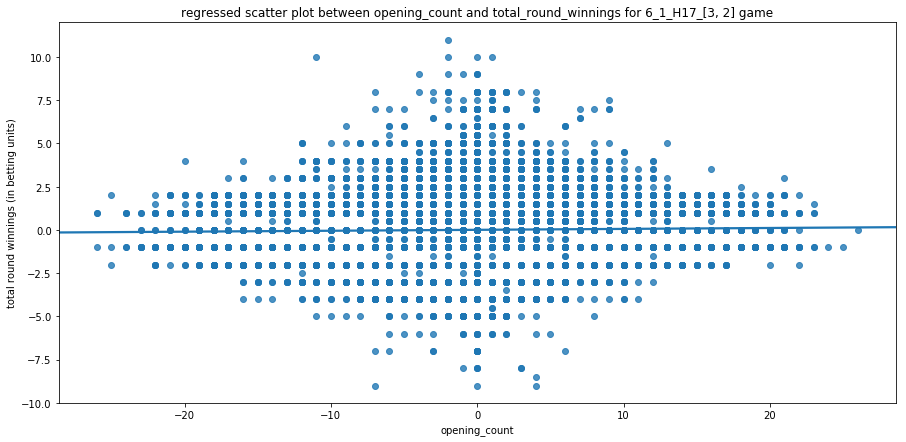

In [59]:
sns.regplot(x=df['opening_count'], y=df['total_round_winnings'])
plt.xlabel('opening_count')
plt.ylabel('total round winnings (in betting units)')
plt.title('regressed scatter plot between opening_count and total_round_winnings for 6_1_H17_[3, 2] game')
plt.savefig('plots/6_1_H17_[3, 2]_regplot.jpeg')
plt.show()

## Correlation between change in count and total round winnings

We next examine the correlation between change in count and total round winnings as we suspect that the change in count is actually what is related to the total round winnings (and since the counting system is balanced, a nonzero count is more likely to turn around in the opposite direction)

In [62]:
# first create the column for change in counts: count_delta

df['count_delta'] = np.append(np.diff(df['opening_count']),[0])
df.head()

,Unnamed: 0,decks,pen,Blackjack_pays,Dealer_seventeen,strategy,spread,opening_count,cards_left,spots,...,double_down,player_hands,dealer_hand,player_results,dealer_result,insurance,player_winnings_by_hand,total_round_winnings,accumulated_winnings,count_delta
0,0,6,1,"[3, 2]",H17,basic,NaN,0,307,1,...,[False],"[[8, 5, 10]]","[10, 10]",[['bust']],['stand'],False,[-1.0],-1.0,-1.0,0
1,1,6,1,"[3, 2]",H17,basic,NaN,0,299,1,...,[False],"[[10, 6]]","[4, 5, 3, 'A', 3, 5]",[['stand']],['stand'],False,[-1.0],-1.0,-2.0,0
2,2,6,1,"[3, 2]",H17,basic,NaN,0,294,1,...,[False],"[[9, 4, 6]]","[10, 10]",[['stand']],['stand'],False,[-1.0],-1.0,-3.0,0
3,3,6,1,"[3, 2]",H17,basic,NaN,0,288,1,...,[False],"[[10, 10]]","[2, 5, 6, 7]",[['stand']],['stand'],False,[0.0],0.0,-3.0,0
4,4,6,1,"[3, 2]",H17,basic,NaN,0,283,1,...,[False],"[[8, 10]]","['A', 'A', 9]",[['stand']],['stand'],False,[-1.0],-1.0,-4.0,0


In [64]:
# obtain correlation coefficient between count delta and total round winnings

coef, p_val = stats.pearsonr(df['count_delta'],df['total_round_winnings'])
print('correlation coefficient: ', coef)
print('p-value: ', p_val)

correlation coefficient:  -0.048813587654906156
p-value:  0.0


The change in count and total round winnings are negatively correlated.  This makes sense because the count and total round winnings are positively related, and a high count corresponds to more 10s and aces in the deck, and that is beneficial for the player.  10s and aces are only benefecial to the player if they actually show up.  So the winnings are higher when the a 10 or aces is dealt to a player/dealer, and that corresponds to the count decreasing.

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


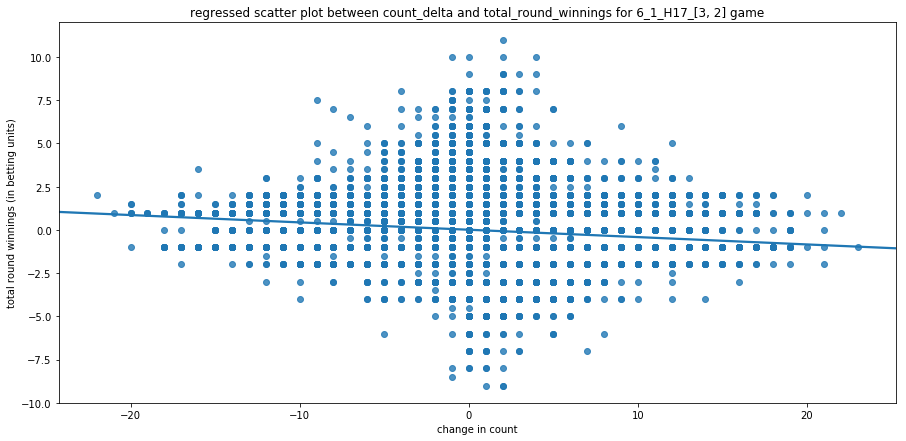

In [65]:
sns.regplot(x=df['count_delta'], y=df['total_round_winnings'])
plt.xlabel('change in count')
plt.ylabel('total round winnings (in betting units)')
plt.title('regressed scatter plot between count_delta and total_round_winnings for 6_1_H17_[3, 2] game')
plt.savefig('plots/6_1_H17_[3, 2]_regplot_count_delta.jpeg')
plt.show()